# Controlling the chatbot memory

We follow the [langgraph tutorial](https://langchain-ai.github.io/langgraph/tutorials/introduction/) to learn the basics about memory by building a simple chatbot.

So far, we have been prototyping chatbots that do not have any memory of previous messages in context.
Here, we will explore how to keep a memory in two ways, and how to use it to rewind and branch off from different points in the conversation.

# Build a basic chatbot

By now, we know how to build a simple chatbot.
We will keep it as simple as possible (without tools) to be able to focus on the memory part.

In [ ]:
from typing import Annotated

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

load_dotenv()
llm = init_chat_model(model="anthropic:claude-3-5-sonnet-latest")

The graph will take a user input, pass it to the LLM, and directly return the response.

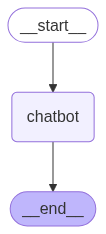

In [ ]:
class State(TypedDict):
    # The state contains the message history: a list that we change with the add_messages function
    # New messages are appended to the list, rather than replacing the previous ones.
    messages: Annotated[list, add_messages]


def chatbot(state: State) -> State:
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

# Manually handle the state

The state contains the message history.
The simplest way to implement a memory for our chatbot is by manually handling the state between interactions in our chat loop.

In [ ]:
state = {"messages": []}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    state["messages"] = state.get("messages", []) + [{"role": "user", "content": user_input}]
    state = graph.invoke(state)

    print("User:", user_input)
    if state.get("messages") and len(state["messages"]) > 0:
        print("Assistant:", state["messages"][-1].content)  # Print the last message
        print("\n")

User: Hi, my name's Borja. Nice to meet you!
Assistant: Hi Borja! Nice to meet you too! I'm Claude, an AI assistant created by Anthropic. How can I help you today?


User: Could you write a word starting with every letter in my name?
Assistant: Here are words starting with each letter in "BORJA":

B - Beautiful
O - Organic
R - Radiant
J - Jovial
A - Adventurous


User: Thanks, that was great!
Assistant: You're welcome, Borja! Glad I could help! Let me know if you'd like to try anything else 😊


Goodbye!


In every pass of the loop, we add the user input to the current state, and then get the new state by invoking the graph.
This allows the LLM to keep the previous interactions in context and have a coherent conversation.
In this case, we first give the chatbot a name, and then ask it to perform a task with the name without repeating it.
Without a memory, the task would be impossible to do!

# Checkpointing

LangGraph offers functionality to checkpoint the state at every step in the conversation.
To do so, we need to provide a `checkpointer` when compiling the graph, as well as an ID for the thread when calling it.

Checkpointing this way is much more powerful than simply keeping a chat memory.
It will allow us to move freely along the conversation, restart it from any given point, branch off separate threads, etc.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver  # noqa: E402

memory = MemorySaver()
# This memory saver keeps the checkpointing in memory. In production, we'd use
# a checkpointer that connects to a database.

graph = graph_builder.compile(checkpointer=memory)  # Compile the graph with a checkpointer

Now to use this graph, we need to provide it with a configuration that contains the thread ID.
**The thread ID should be a string!!!**
Apparently, it is converted into string internally and we may get unexpected behaviours with mismatching namespaces.

In [ ]:
config = {"configurable": {"thread_id": "0"}}

Let's check how it works!

In [ ]:
def stream_message(content, configuration):
    "Stream a message and print it."
    events = graph.stream(
        {"messages": [{"role": "user", "content": content}]}, configuration, stream_mode="values"
    )
    for event in events:
        event["messages"][-1].pretty_print()

In [ ]:
while True:
    user_input = input("User: ")
    # Terminate the conversation with quit, exit or q
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_message(user_input, config)

================================ Human Message =================================

Hi, my name's Borja. Nice to meet you!
================================== Ai Message ==================================

Hi Borja! Nice to meet you too! I'm an AI assistant. How can I help you today?
================================ Human Message =================================

Could you write a word starting with every letter in my name?
================================== Ai Message ==================================

Here are words starting with each letter in "BORJA":

B - Beautiful
O - Ocean
R - Rainbow
J - Journey
A - Adventure
================================ Human Message =================================

Thanks, that was great!
================================== Ai Message ==================================

You're welcome, Borja! Glad I could help! Let me know if you need anything else 😊
Goodbye!


Great! We see the information about the name is kept across interactions.


## Switching threads

Let's try now creating a new thread.
New threads will be fresh conversations, and the previously checkpointed ones will be preserved.
Let's see the effect by asking the chatbot about the name we gave it. 

In [ ]:
question = "What is my name?"

In the new thread, the chatbot has no context.

In [ ]:
other_config = {"configurable": {"thread_id": "1"}}  # Other thread

stream_message(question, other_config)

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

I don't know your name. You haven't shared it with me. Would you like to tell me your name?


In the original thread, the question is answered without a problem.

In [ ]:
stream_message(question, config)  # Back to the same thread

================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Your name is Borja.


## Checkpoints

What exactly are checkpoints?
We can inspect the graph's state for a given config (specific thread).
Let's look at the main thread's state.

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content="Hi, my name's Borja. Nice to meet you!", additional_kwargs={}, response_metadata={}, id='bd3b692c-0908-4de9-819f-65d9f14460e1'), AIMessage(content="Hi Borja! Nice to meet you too! I'm an AI assistant. How can I help you today?", additional_kwargs={}, response_metadata={'id': 'msg_017AbgQfaVPG4DUzc63eZ5hN', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 21, 'output_tokens': 27, 'server_tool_use': None}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run--e6f74635-81ca-493b-a3ef-3721ea117206-0', usage_metadata={'input_tokens': 21, 'output_tokens': 27, 'total_tokens': 48, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='Could you write a word starting with every letter in my name?', additional_kwargs={}, response_metadata={}, id='62f726a3-6b76-46b5-8d86-cb01a7bce0

The checkpoint contains the full history of our interactions.
For example, we can print the full conversation even though it has been created in two separate sessions.

In [ ]:
for message in snapshot.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi, my name's Borja. Nice to meet you!
================================== Ai Message ==================================

Hi Borja! Nice to meet you too! I'm an AI assistant. How can I help you today?
================================ Human Message =================================

Could you write a word starting with every letter in my name?
================================== Ai Message ==================================

Here are words starting with each letter in "BORJA":

B - Beautiful
O - Ocean
R - Rainbow
J - Journey
A - Adventure
================================ Human Message =================================

Thanks, that was great!
================================== Ai Message ==================================

You're welcome, Borja! Glad I could help! Let me know if you need anything else 😊
================================ Human Message =================================

What is my name?
=======

# Navigating the conversation

Saving checkpoints for every step of the graph allows us to rewind and move back and forth in the conversation.
Additionally, we can retake it from any point in time and branch off in another thread to explore alternative conversation paths, or even just regenerate the same step.

Let's check how it works!

We will start with a new thread.

In [ ]:
config = {"configurable": {"thread_id": "2"}}

Now let's have a couple of interactions with the chatbot.

In [ ]:
while True:
    user_input = input("User: ")
    # Terminate the conversation with quit, exit or q
    if user_input.lower() in ["quit", "exit", "q"]:
        break

    stream_message(user_input, config)

================================ Human Message =================================

Hi Claude!
================================== Ai Message ==================================

Hi! Nice to meet you. How can I help you today?
================================ Human Message =================================

Let's play a little game. Would you like to?
================================== Ai Message ==================================

Sure, I'd be happy to play a game with you! What kind of game did you have in mind?
================================ Human Message =================================

Let me explain: I will provide a word and you write an animal name that starts with every letter of the word. Is it clear?
================================== Ai Message ==================================

Yes, that's very clear! For example, if you give me the word "CAT", I would write:
C - Cheetah
A - Antelope
T - Tiger

I'm ready for your word! What will it be?
================================ Hum

Now that we have had a few interactions with the chatbot, we can inspect the _state history_.

In the previous section, we have seen what the state at the end of the conversation with `graph.get_state`.
The state history contains the collection of state snapshots after every interaction with the chatbot with the most recents first.

In [ ]:
for state in graph.get_state_history(config):
    print(state)

StateSnapshot(values={'messages': [HumanMessage(content='Hi Claude!', additional_kwargs={}, response_metadata={}, id='baa5cbbf-c647-472f-8e9e-508ae0731975'), AIMessage(content='Hi! Nice to meet you. How can I help you today?', additional_kwargs={}, response_metadata={'id': 'msg_01R9R1ecDJ21NELrtZ9qTeQx', 'model': 'claude-3-5-sonnet-latest', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 17, 'server_tool_use': None}, 'model_name': 'claude-3-5-sonnet-latest'}, id='run--aaaf22ae-e80e-4e2b-958f-c5fbf7efc078-0', usage_metadata={'input_tokens': 10, 'output_tokens': 17, 'total_tokens': 27, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content="Let's play a little game. Would you like to?", additional_kwargs={}, response_metadata={}, id='96b5c705-f1f8-413c-99f8-eeca7dd56762'), AIMessage(content="Sure, I'd be happy to play a game with you! What kind o

Every state has a `config` that contains information about the checkpoint id within the thread. For example, let's see the one from the first snapshot in the conversation (last one in the loop).

In [ ]:
state.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02fe50-3cd4-634e-bfff-6ba7f4e838a6'}}

Furthermore, we can see what node will be executed next following a given state.
In the case of the first snapshot in the empty conversation, we can expect the start node to be execute next.

In [ ]:
state.next

('__start__',)

## Changing a previous interaction

We can use the config from any snapshot in the history to branch off the conversation from that given point onwards.
This allows us to explore different conversation paths and outcomes.
For example, let's change the word we provided in the game.
The word was the second-to-last interaction, so we need to branch off from the previous AI response.

In [ ]:
states = list(graph.get_state_history(config))
to_replay = states[2]
to_replay.values["messages"][-1]  # Last message before providing the word

AIMessage(content='Yes, that\'s very clear! For example, if you give me the word "CAT", I would write:\nC - Cheetah\nA - Antelope\nT - Tiger\n\nI\'m ready for your word! What will it be?', additional_kwargs={}, response_metadata={'id': 'msg_01CQ7Auv12QUdZSphWfg3S53', 'model': 'claude-3-5-sonnet-latest', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 99, 'output_tokens': 57, 'server_tool_use': None}, 'model_name': 'claude-3-5-sonnet-latest'}, id='run--d79981a1-de5c-4ac1-941b-64895e0ab7ba-0', usage_metadata={'input_tokens': 99, 'output_tokens': 57, 'total_tokens': 156, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})

Now, we just need to provide the config from the point we want to move on when we add a new message.

In [ ]:
new_user_input = "dishwasher"
stream_message(new_user_input, to_replay.config)  # Use the branch off point config

================================ Human Message =================================

dishwasher
================================== Ai Message ==================================

Here are animals for each letter in "dishwasher":

D - Dolphin
I - Impala
S - Salamander
H - Hippopotamus
W - Walrus
A - Alligator
S - Sloth
H - Hawk
E - Eagle
R - Rhinoceros


The chatbot is fully aware of the game we are playing and provided a correct response.
The current state of the conversation contains the messages for this new "branch".

In [ ]:
last_state = graph.get_state(config)
for message in last_state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi Claude!
================================== Ai Message ==================================

Hi! Nice to meet you. How can I help you today?
================================ Human Message =================================

Let's play a little game. Would you like to?
================================== Ai Message ==================================

Sure, I'd be happy to play a game with you! What kind of game did you have in mind?
================================ Human Message =================================

Let me explain: I will provide a word and you write an animal name that starts with every letter of the word. Is it clear?
================================== Ai Message ==================================

Yes, that's very clear! For example, if you give me the word "CAT", I would write:
C - Cheetah
A - Antelope
T - Tiger

I'm ready for your word! What will it be?
================================ Hum

## Regenerating a response

We can ask the chatbot to repeat a response it previously provided in the same way that we have changed a message in the middle of the conversation.
For example, we can ask it to regenerate the last message in this conversation.

To do so, we need to start from our last message and let the chatbot do "its thing" by not providing a message.

In [ ]:
states = list(graph.get_state_history(config))
to_replay = states[1]
to_replay.values["messages"][-1]  # Our last message

HumanMessage(content='dishwasher', additional_kwargs={}, response_metadata={}, id='cc91bca4-b24d-4a08-b7ba-5474fefd3105')

In [ ]:
events = graph.stream(None, to_replay.config, stream_mode="values")  # No message
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

dishwasher
================================== Ai Message ==================================

Here are animals for each letter in "dishwasher":

D - Dolphin
I - Iguana 
S - Sloth
H - Hippopotamus
W - Walrus
A - Antelope
S - Salamander
H - Hedgehog
E - Eagle
R - Rhinoceros


The new conversation contains the regenerated response!

In [ ]:
last_state = graph.get_state(config)
for message in last_state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi Claude!
================================== Ai Message ==================================

Hi! Nice to meet you. How can I help you today?
================================ Human Message =================================

Let's play a little game. Would you like to?
================================== Ai Message ==================================

Sure, I'd be happy to play a game with you! What kind of game did you have in mind?
================================ Human Message =================================

Let me explain: I will provide a word and you write an animal name that starts with every letter of the word. Is it clear?
================================== Ai Message ==================================

Yes, that's very clear! For example, if you give me the word "CAT", I would write:
C - Cheetah
A - Antelope
T - Tiger

I'm ready for your word! What will it be?
================================ Hum